## About

Notebook to fetch ECG, calculate HR abd HRV values

In [3]:
root_folder = "./../"
sys.path.insert(1, root_folder)
sys.path.insert(1, os.path.join(root_folder, 'tools/'))

#%%
import sys
import getopt

#Imports
import numpy as np
import multiprocessing # todo
from os.path import join as ospj
import sys
import pandas as pd
import seaborn as sns
from ieeg.auth import Session
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tqdm import tqdm
from tools import get_iEEG_data
from numpy.lib.stride_tricks import sliding_window_view
from scipy.signal import iirnotch, filtfilt, butter, lfilter, medfilt

import warnings
warnings.filterwarnings("ignore")

import biosppy
from biosppy.signals import ecg
import pyhrv
import pyhrv.tools as tools
from pyhrv.hrv import hrv
import neurokit2 as nk
import heartpy as hp
import pyhrv.time_domain as td 
import pyhrv.frequency_domain as fd

from datetime import datetime, date, timedelta
import importlib

from scipy import signal
from scipy.signal import butter, lfilter, freqz, filtfilt, find_peaks, medfilt, ellip
from scipy.signal import savgol_filter, hilbert
import sys
import os
import json



from helpers import *


    

In [4]:
def remove_std(signal, std_mul=1.5):
    std_rem = signal.copy()
    mean = np.mean(std_rem)
    std = np.std(std_rem)
    std_rem[(std_rem<(mean+std_mul*std)) & (std_rem>(mean-std_mul*std))]=mean
    return std_rem

In [5]:
username = 'jalpanchal'
pwd_bin_path = "/users/jalp/tools/jal_ieeglogin.bin"
with open(pwd_bin_path, "r") as f:
    s = Session(username, f.read())   
    
#import login credentials
from cryptography.fernet import Fernet
import os
 
cred_filename = '/users/jalp/ieeg_credentials/CredFile.ini'
key_file = '/users/jalp/ieeg_credentials/key.key'
 
key = ''
 
with open(key_file,'r') as key_in:
    key = key_in.read().encode()
  
f = Fernet(key)
with open(cred_filename,'r') as cred_in:
    lines = cred_in.readlines()
    config = {}
    for line in lines:
        tuples = line.rstrip('\n').split('=',1)
        if tuples[0] in ('Username','Password'):
            config[tuples[0]] = tuples[1]
 
    password = f.decrypt(config['Password'].encode()).decode()
    user = config['Username']

### Load subject data and seizure timestamps

In [6]:
subject_data = pd.read_csv("./../../data/subject_data.csv")
print(subject_data)

    Unnamed: 0 subject           portal_ID     ecg_channel  ecg_multiplier
0            0  HUP064       HUP64_phaseII    EEG EKG2-Ref               1
1            1  HUP065       HUP65_phaseII  EEG EKG 01-Ref               1
2            2  HUP068       HUP68_phaseII  EEG EKG 02-Ref               1
3            3  HUP070       HUP70_phaseII    EEG EKG2-Ref               1
4            4  HUP073       HUP73_phaseII  EEG EKG 01-Ref              -1
5            5  HUP074       HUP74_phaseII  EEG EKG 02-Ref               1
6            6  HUP075       HUP75_phaseII    EEG EKG2-Ref               1
7            7  HUP078       HUP78_phaseII  EEG EKG 02-Ref               1
8            8  HUP080       HUP80_phaseII  EEG EKG 01-Ref              -1
9            9  HUP083       HUP83_phaseII  EEG EKG 02-Ref               1
10          10  HUP086       HUP86_phaseII  EEG EKG 01-Ref              -1
11          11  HUP087       HUP87_phaseII  EEG EKG 02-Ref               1
12          12  HUP088   

In [7]:
sz_data = pd.read_excel("/users/jalp/git/ecg-ieeg/data/seizure_metadata_with_severity.xlsx")
print(sz_data)

     Unnamed: 0 Patient  Seizure number Seizure type Seizure category  \
0             3  HUP064               0        FBTCS            FBTCS   
1             4  HUP065               0        FBTCS            FBTCS   
2             5  HUP065               1        FBTCS            FBTCS   
3             6  HUP065               2        FBTCS            FBTCS   
4             7  HUP068               0        FBTCS            FBTCS   
..          ...     ...             ...          ...              ...   
251         317  HUP191              10  Subclinical            Other   
252         318  HUP191              11  Subclinical            Other   
253         319  HUP191              12  Subclinical            Other   
254         320  HUP191              13  Subclinical            Other   
255         321  HUP191              14         FIAS            Focal   

     Seizure EEC  Seizure UEO  Seizure end   iEEG Filename  Seizure duration  \
0       632657.0    632666.73     632764.0 

### Calculate data segments
1 min segments, can change to 5 mins
- Segments used from
/users/pattnaik/ecg-ieeg/data/sub-RID0031/all_clip_times.xlsx for each subject has the start and end timiing of each segment\

In [35]:
def calc_hrv_param(data, win_s, overlap_s):
    df = data.copy()

    start =df.index[0]
    stop = df.index[-1]

    hrv_windows = calc_windows(start, stop, win_s, overlap_s)

    hrv_df = pd.DataFrame()
    for i in range(len(hrv_windows)):
        data = df[(df.index >=hrv_windows[i][0]) & (df.index <hrv_windows[i][1])]['heartRate']
        
        if len(data.dropna())>=2:

            nni_ms = 60000/data.values

            #dropping large nni values > 3000 ms
            nni_ms = nni_ms[nni_ms < 3000]



            # print(len(nni_ms))
            # td_results = td.time_domain(nni=nni_ms, rpeaks =rpeaks_ms, sampling_rate=fs,plot=False)
            parameters = ['rmssd', 'hf']

            # hrv_params = np.ones([len(data), len(parameters)])*np.nan
            # hrv_params[-1,0] =  int(td.rmssd(nni=nni_ms)[0])
            rmssd = int(td.rmssd(nni=nni_ms)[0])
            
            #frequency based parameter 
            # try:
            #     freq = fd.welch_psd(nni=nni_ms, show=False, mode='dev')[0]['fft_abs']
            #     hrv_params[-1,1] =  int(freq[2])
            # except : 
            #     hrv_params[-1,1] =  0
            
            hrv_df = hrv_df.append(pd.DataFrame(data={'rmssd' : rmssd, 'hrMean' : round(np.mean(data.values),1) }, index=[data.index[-1]]))

        else:
            continue
    return hrv_df    

def get_hr_hrv(subject_name, start_flag=0, end_flag=0 ):

    sub_data = subject_data[subject_data['subject']==subject_name]

    portal_name = sub_data['portal_ID'].iloc[0]
    # print("portal_name", portal_name)
    ecg_channels = [sub_data['ecg_channel'].iloc[0]]
    ecg_multiplier = sub_data['ecg_multiplier'].iloc[0]


    #Configuring getting  ieeg data
    # print("Getting data for %s" %(subject_name))
    # print("Getting data for %s from IEEG" %(portal_name))

    with open(pwd_bin_path, "r") as f:
        s = Session(username, f.read())
    ds = s.open_dataset(portal_name)

    if start_flag!=0:
        start_time_sec = int(start_flag)
    else:
        start_time_sec = 0

    if end_flag!=0:
        end_time_sec = int(end_flag)
    else:
        end_time_sec = (ds.end_time-ds.start_time)/1e6
    

    # print("time stamps retrived from IEEG")
    # print("Getting data for %s from %d to %d" %(subject_name, start_time_sec, end_time_sec))

    data_pull_min=1

    clip_duration_sec =  end_time_sec - start_time_sec
    clip_duration_min = clip_duration_sec / 60

    # how many data_pull_min minute data pulls are there?
    n_iter = int(np.ceil(clip_duration_min / data_pull_min))


# %%
    
    hr_win = pd.DataFrame()
    for i in range(n_iter):

        start_usec = start_time_sec * 1e6 + i * (data_pull_min * 60 * 1e6)
        if i == n_iter - 1:
            end_usec = end_time_sec * 1e6
        else:
            end_usec = start_usec + (data_pull_min * 60 * 1e6)

        data, fs = get_iEEG_data(username, pwd_bin_path,portal_name , start_usec, end_usec, select_electrodes=ecg_channels)

        time = np.linspace(start_usec, end_usec, len(data), endpoint=False)
        data.index = pd.to_datetime(time, unit='us')


        # format resulting data into pandas DataFrame
        signal_filt = pd.DataFrame(columns=ecg_channels, index=data.index)


        hr_df = pd.DataFrame()
        for n,c in enumerate(ecg_channels):
            #remove baseline wander
            temp_ = hp.remove_baseline_wander(data.iloc[:,n]*ecg_multiplier, fs)


            #bandpas filter
            order = int(0.3 * fs)
            signal_filt[c], _, _ = biosppy.tools.filter_signal(signal=temp_,ftype='FIR',band='bandpass',order=order,frequency=[3,25],sampling_rate=fs)


            # work on 5s samples
            temp_std= pd.DataFrame()
            for i in range(int(len(signal_filt)/int(5*fs))):

                win_data = signal_filt[i*5*int(fs):(i+1)*5*int(fs)][c]

                #remove noise data < 1.5 std

                std_rem = remove_std(win_data, 1.5)
                temp_std = temp_std.append(pd.DataFrame(std_rem))

            try :
            
                out = ecg.ecg(signal=temp_std[c], sampling_rate=fs, show=False)
                # ecg_filtered = out[1]
                # rpeaks = out[2]
                heart_rate_ts = out[-2]
                heart_rate = out[-1]
                idx = (heart_rate_ts*fs).astype(int)

                temp_ = pd.DataFrame(data={c : heart_rate}, index=temp_std.index[idx])
                hr_df = hr_df.append(temp_)

                                
                #shift time to real time
                # hr_df.index = pd.to_datetime(hr_df.index).tz_localize(tz=tz)+ delta

                # resample to 1Hz
                hr_rs = hr_df.resample("1s").mean()   

                #take the min in each 1s window
                hr_min = hr_rs.min(axis=1)

                hr_win = hr_win.append(pd.DataFrame(hr_min.dropna()))
            except:
                    continue  

    # %%
    #smoothen
    hr_sm = pd.DataFrame({'heartRate' : savgol_filter(hr_win[0], 11,3)}, index=hr_win.index)
    hr_sm['heartRate'] = hr_sm['heartRate'].apply(lambda x : round(x,1))



    # %%
    #calc hrv parameters

    # hrv_df = calc_hrv_param(hr_sm, 60,50) #60s window 50s overlap
    hrv_df = calc_hrv_param(hr_sm, 60,0) #60s window 0s overlap

    #combine df and add timestamp column
    combine_df = hr_sm.join(hrv_df)
    combine_df['timestamp'] = (combine_df.index.astype(int)/10e8).astype(int)
    combine_df = combine_df[['timestamp', 'heartRate', 'rmssd', 'hrMean']]

    return combine_df



### Running for each Seizure segment

In [9]:
for sub in subject_data['subject'].values[-2:]:

    sz_times = sz_data[sz_data['Patient']==sub]
    # print(sz_times)

    for sz in range(len(sz_times)):
        sz_num = sz_times['Seizure number'].iloc[sz]
        sz_eec  = sz_times['Seizure EEC'].iloc[sz]
        # print(sz_eec)

        
        start_time = int(sz_eec-60*60) #1 hour before eec
        end_time = int(sz_eec)

        file_name = "./../../data/"+sub+"_sz_"+str(sz_num)+"_ecg_hr_hrv"

        # print(file_name)
        # print(start_time, end_time)

        hrv = get_hr_hrv(sub, start_flag=start_time, end_flag=end_time)
        hrv_np = hrv.to_numpy()
        np.save(file_name, hrv_np)



  0%|          | 0/12 [00:00<?, ?it/s]

Getting data for HUP190 from 555518 to 559118


  0%|          | 0/12 [00:00<?, ?it/s]

Getting data for HUP190 from 561390 to 564990


  0%|          | 0/12 [00:00<?, ?it/s]

Getting data for HUP190 from 595295 to 598895


 92%|█████████▏| 11/12 [00:15<00:01,  1.36s/it]

### Computing inter-ictal segments

In [40]:
for sub in tqdm(subject_data['subject'].values[6:]):
    try:
        file_name="/mnt/leif/littlab/users/pattnaik/sz_sev_preictal/data/patients/"+sub+"/interictal_clip_times.npy"
        inter_ictal_times = pd.DataFrame(np.load(file_name))
        hrv =pd.DataFrame()
        for clips in inter_ictal_times.iterrows():
            start_time=clips[1].values[0]
            end_time = start_time+60

            temp = get_hr_hrv(sub, start_flag=start_time, end_flag=end_time)
            hrv = hrv.append(temp.dropna())
            # print(hrv)
        file_name = "./../../data/"+sub+"_inter_"+"_ecg_hr_hrv"
        hrv_np = hrv.to_numpy()
        #delete HR column
        hrv_np=np.delete(hrv_np, 1,1)
        np.save(file_name, hrv_np)
    except Exception as e:
        print(e)
        continue



  2%|▏         | 1/48 [00:00<00:32,  1.44it/s]

0


  4%|▍         | 2/48 [00:05<02:25,  3.17s/it]

0


 10%|█         | 5/48 [00:53<08:27, 11.79s/it]

0


 12%|█▎        | 6/48 [01:01<07:19, 10.46s/it]

0


 15%|█▍        | 7/48 [01:11<07:08, 10.44s/it]

If mode is 'interp', window_length must be less than or equal to the size of x.


 17%|█▋        | 8/48 [01:16<05:42,  8.56s/it]

0


 19%|█▉        | 9/48 [01:29<06:32, 10.07s/it]

If mode is 'interp', window_length must be less than or equal to the size of x.


 21%|██        | 10/48 [01:55<09:31, 15.03s/it]

0


 25%|██▌       | 12/48 [02:54<13:32, 22.56s/it]

0


 27%|██▋       | 13/48 [03:07<11:22, 19.51s/it]

If mode is 'interp', window_length must be less than or equal to the size of x.


 33%|███▎      | 16/48 [04:14<10:50, 20.34s/it]

If mode is 'interp', window_length must be less than or equal to the size of x.


 35%|███▌      | 17/48 [04:44<12:03, 23.32s/it]

[Errno 2] No such file or directory: '/mnt/leif/littlab/users/pattnaik/sz_sev_preictal/data/patients/HUP125/interictal_clip_times.npy'


 44%|████▍     | 21/48 [05:45<07:45, 17.22s/it]

If mode is 'interp', window_length must be less than or equal to the size of x.


 48%|████▊     | 23/48 [06:13<06:11, 14.85s/it]

0


 56%|█████▋    | 27/48 [07:53<07:00, 20.04s/it]

0


 60%|██████    | 29/48 [08:35<06:25, 20.30s/it]

0


 62%|██████▎   | 30/48 [08:43<05:02, 16.83s/it]

0


 85%|████████▌ | 41/48 [14:10<03:02, 26.03s/it]

If mode is 'interp', window_length must be less than or equal to the size of x.


100%|██████████| 48/48 [18:09<00:00, 22.70s/it]


In [30]:
np.delete(hrv_np,1,1)

array([[8.90176e+05, 5.50000e+01, 8.02000e+01],
       [4.14149e+05, 3.80000e+01, 6.94000e+01],
       [4.62536e+05, 4.00000e+00, 6.66000e+01],
       [8.74444e+05, 3.20000e+01, 8.47000e+01],
       [8.49362e+05, 3.80000e+01, 6.06000e+01],
       [8.38360e+05, 2.70000e+01, 5.87000e+01],
       [8.75609e+05, 3.30000e+01, 9.65000e+01],
       [8.39004e+05, 3.80000e+01, 5.83000e+01],
       [4.13540e+05, 1.20000e+01, 6.36000e+01],
       [4.50533e+05, 4.10000e+01, 6.62000e+01],
       [4.48762e+05, 1.90000e+01, 6.54000e+01],
       [4.43646e+05, 2.80000e+01, 6.45000e+01],
       [4.23942e+05, 3.00000e+00, 6.75000e+01],
       [4.16407e+05, 5.00000e+00, 6.55000e+01],
       [4.40479e+05, 1.60000e+01, 6.88000e+01],
       [8.66849e+05, 8.00000e+01, 7.58000e+01],
       [8.77481e+05, 4.90000e+01, 8.84000e+01],
       [4.47661e+05, 4.70000e+01, 6.24000e+01],
       [8.41391e+05, 2.70000e+01, 5.58000e+01],
       [8.70199e+05, 3.40000e+01, 7.97000e+01]])

### running HR-HRV for whole dataset

In [11]:
file_name = "./../../data/HUP173/HUP173_ecg_hr_hrv_test"
hrv = get_hr_hrv('HUP173', 0, 100000)
hrv_np = hrv.to_numpy()
np.save(file_name, hrv_np)

  0%|          | 0/334 [00:00<?, ?it/s]

Getting data for 0 to 100000


  2%|▏         | 6/334 [00:18<16:53,  3.09s/it]


KeyboardInterrupt: 

## Load smaple data

In [16]:
file_name = "HUP065_sz_2_ecg_hr_hrv.npy"
file_path = "/mnt/leif/littlab/users/jalp/git/ecg-ieeg/data/"+file_name
test_df = pd.DataFrame(np.load(file_path))
test_df.columns = ['timestamp', 'heartRate', 'rmssd', 'hrMean']

### Sample Plot

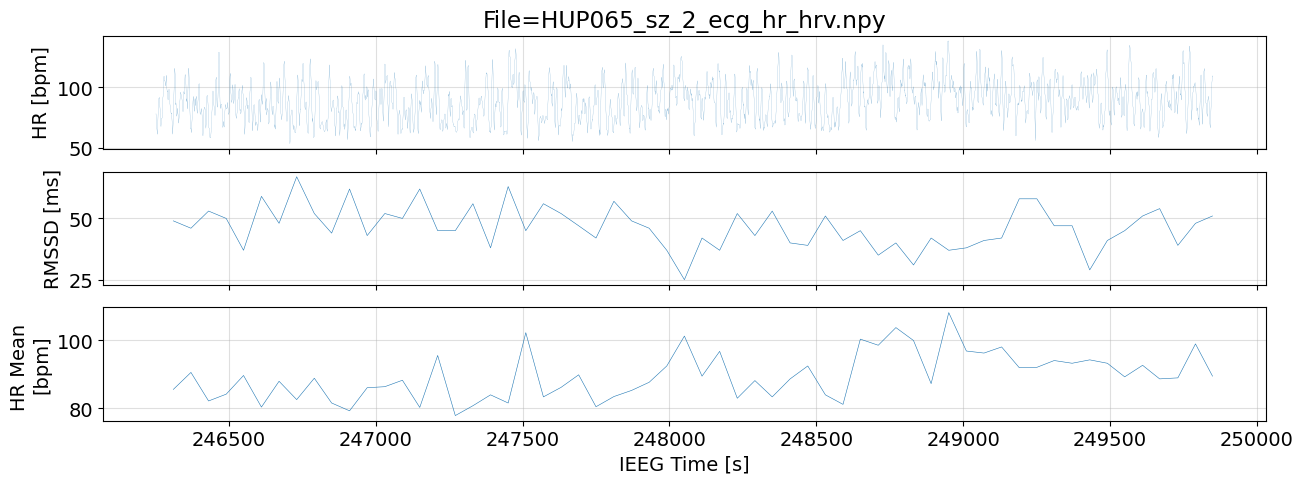

In [17]:
plt.rcParams["font.size"]=14
fig, ax = plt.subplots(3,1, figsize=(15,5), sharex=True)
user_data = test_df.copy()
axi = ax[0]
axi.plot(user_data['timestamp'],user_data['heartRate'], '-', lw=0.1)
axi.set_ylabel("HR [bpm]")
axi.set_title("File=%s"%(file_name))

data_copy = user_data.copy()
data_copy = data_copy.dropna()

axi = ax[1]
axi.plot(data_copy['timestamp'],data_copy['rmssd'], '-', lw=0.4)
axi.set_ylabel("RMSSD [ms]")
# axi.set_xlabel("IEEG Time [s]")

axi = ax[2]
axi.plot(data_copy['timestamp'],data_copy['hrMean'], '-', lw=0.4)
axi.set_ylabel("HR Mean \n[bpm]")
axi.set_xlabel("IEEG Time [s]")

for axp in ax.flatten():
    axp.grid(alpha=0.4)

plt.show()